In [103]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

In [104]:
class Transformer(nn.Module):
    # Constructor
    def __init__( self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,  #  the number of expected features in the encoder/decoder inputs (default=512)
            nhead=num_heads,  # the number of heads in the multiheadattention models (default=8)
            num_encoder_layers=num_encoder_layers,  # the number of sub-encoder-layers in the encoder (default=6)
            num_decoder_layers=num_decoder_layers,  # the number of sub-decoder-layers in the decoder (default=6)
            dropout=dropout_p,  # the dropout value (default=0.1)
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src, Tgt size are must be (batch_size, src sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

In [105]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()

        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [132]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data

In [133]:
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):

        if idx + batch_size < len(data):

            if padding:
                max_batch_length = 0

                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)


                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


In [134]:
print(generate_random_data(10))

[[array([2., 0., 1., 0., 1., 0., 1., 0., 1., 3.]), array([2., 0., 1., 0., 1., 0., 1., 0., 1., 3.])], [array([2., 1., 0., 1., 0., 1., 0., 1., 0., 3.]), array([2., 1., 0., 1., 0., 1., 0., 1., 0., 3.])], [array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.]), array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.])], [array([2., 1., 0., 1., 0., 1., 0., 1., 0., 3.]), array([2., 1., 0., 1., 0., 1., 0., 1., 0., 3.])], [array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.]), array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.])], [array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.])], [array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.])], [array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.]), array([2., 0., 0., 0., 0., 0., 0., 0., 0., 3.])], [array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.]), array([2., 1., 1., 1., 1., 1., 1., 1., 1., 3.])]]


In [135]:
train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


In [125]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [126]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [127]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:,:-1]
            y_expected = y[:,1:]

            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [138]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):  
    train_loss_list, validation_loss_list = [], []

    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()

    return train_loss_list, validation_loss_list

train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 20
                                           )

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.1816
Validation loss: 0.1127

------------------------- Epoch 2 -------------------------
Training loss: 0.1818
Validation loss: 0.1091

------------------------- Epoch 3 -------------------------
Training loss: 0.1803
Validation loss: 0.1174

------------------------- Epoch 4 -------------------------
Training loss: 0.1801
Validation loss: 0.1054

------------------------- Epoch 5 -------------------------
Training loss: 0.1790
Validation loss: 0.1076

------------------------- Epoch 6 -------------------------
Training loss: 0.1750
Validation loss: 0.1774

------------------------- Epoch 7 -------------------------
Training loss: 0.1781
Validation loss: 0.1028

------------------------- Epoch 8 -------------------------
Training loss: 0.1769
Validation loss: 0.1130

------------------------- Epoch 9 -------------------------
Training loss: 0.1760
Validation loss: 0.1040

-------

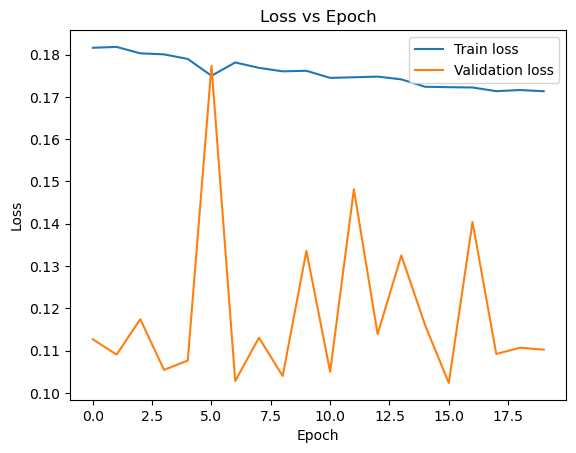

In [139]:
plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [140]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)

        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

In [141]:
# Test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 2, 3]], dtype=torch.long, device=device),
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1]

Example 3
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1]

Example 5
Input: [0, 2]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0]

